In [54]:
# !pip install missingno
# !pip install quilt
# !quilt install ResidentMario/missingno_data

# !pip install xgboost

In [55]:
import matplotlib.pyplot as plt
# import missingno as msno
import numpy as np
import pandas as pd
import quilt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [56]:
data_df = pd.read_csv('titanic.csv')

In [57]:
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger : 승객 고유의 ID값
- **Survived** : 0 = No, 1 = Yes 
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) : 티켓의 class, ~등실 이런것
- **sibsp** : # of siblings & spouses aboard the Titanic : 형제자매, 자신을 제외하고 몇명이 같이탔는지
- **parch** : # of parents / children aboard the Titanic : 직계존속(부모자식), 자신을 제외하고 몇명이 같이탔는지
- **ticket** : Ticket number
- **cabin** : Cabin number : 객실 번호
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) : 승선지

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [58]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [59]:
# msno.matrix(data_df)

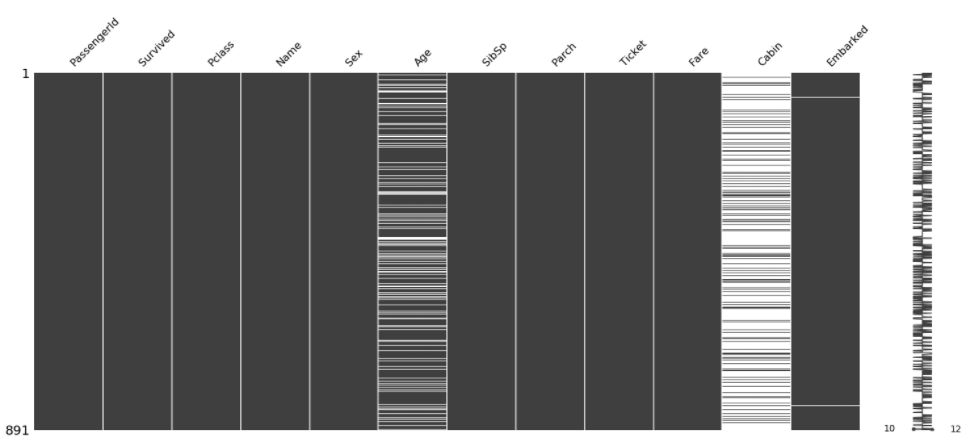

- 결측치를 확인해보니 Age 열과 Cabin 열에 주로 존재함을 볼 수 있었습니다.

#### 데이터 전처리에 따라 결과가 어떻게 달라지는지 보기 위해 총 6가지 방식으로 전처리를 진행하였습니다.

- x_data_1 : 결측치를 중윗값으로 채웠고, 연령대를 범주로 바꿔주었습니다.
- x_data_2 : 결측치를 드랍하였고, 연령대를 그대로 놔두었습니다.
- x_data_3 : 결측치를 중윗값으로 채웠고, 연령대를 그대로 놔두었습니다.
- x_data_4 : x_data_1에 Fare 값을 추가로 더 깨냈습니다.
- x_data_5 : x_data_1에 Fare, SibSp, Parch열을 추가하였습니다.
- x_data_6 : x_data_5 처럼 추가로 열을 꺼냈지만, 연령대를 범주로 바꾸었고, 결측치를 드랍하였습니다.

In [60]:
# Text로 되어있는 Category는 숫자로 바꿔주기
data_df.loc[data_df ["Sex"] == "male", "Sex"] = 0
data_df.loc[data_df ["Sex"] == "female", "Sex"] = 1

# x데이터 추출
x_data_1 = data_df.loc[:, ['Survived', 'Pclass', 'Sex', 'Age']]
x_data_2 = data_df.loc[:, ['Survived', 'Pclass', 'Sex', 'Age']].dropna(axis = 0)
x_data_3 = data_df.loc[:, ['Survived', 'Pclass', 'Sex', 'Age']]
x_data_4 = data_df.loc[:, ['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]
x_data_5 = data_df.loc[:, ['Survived', 'Pclass', 'Sex', 'Age','SibSp', 'Parch', 'Fare']]
x_data_6 = data_df.loc[:, ['Survived', 'Pclass', 'Sex', 'Age','SibSp', 'Parch', 'Fare']].dropna(axis = 0)

# Age NaN 처리: 중위값으로 채움
mean_age = x_data_1['Age'].median(skipna=True) # 중위값
x_data_1['Age'].fillna(mean_age, inplace = True)
x_data_3['Age'].fillna(mean_age, inplace = True)
x_data_4['Age'].fillna(mean_age, inplace = True)
x_data_5['Age'].fillna(mean_age, inplace = True)

# 연령대(Age_group) 범주 생성
for i in range(0, 100, 10):
    #  0 <= 나이대 < 10
    # 10 <= 나이대 < 20
    x_data_1.loc[(x_data_1['Age'] >= i) & (x_data_1['Age'] < i + 10), 'Age_group'] = i
    x_data_4.loc[(x_data_4['Age'] >= i) & (x_data_4['Age'] < i + 10), 'Age_group'] = i
    x_data_5.loc[(x_data_5['Age'] >= i) & (x_data_5['Age'] < i + 10), 'Age_group'] = i
    x_data_6.loc[(x_data_6['Age'] >= i) & (x_data_6['Age'] < i + 10), 'Age_group'] = i

# y_data
y_data_1 = x_data_1[['Survived']]
y_data_2 = x_data_2[['Survived']]
y_data_3 = x_data_3[['Survived']]
y_data_4 = x_data_4[['Survived']]
y_data_5 = x_data_5[['Survived']]
y_data_6 = x_data_6[['Survived']]

# 열 제거
x_data_1.drop(['Survived', 'Age'], axis='columns', inplace=True)
x_data_2.drop(['Survived'], axis='columns', inplace=True)
x_data_3.drop(['Survived'], axis='columns', inplace=True)
x_data_4.drop(['Survived', 'Age'], axis='columns', inplace=True)
x_data_5.drop(['Survived', 'Age'], axis='columns', inplace=True)
x_data_6.drop(['Survived', 'Age'], axis='columns', inplace=True)

In [61]:
x_data_1.head()

,Pclass,Sex,Age_group
0,3,0,20.0
1,1,1,30.0
2,3,1,20.0
3,1,1,30.0
4,3,0,30.0


In [62]:
x_data_2.head()

,Pclass,Sex,Age
0,3,0,22.0
1,1,1,38.0
2,3,1,26.0
3,1,1,35.0
4,3,0,35.0


In [63]:
x_data_3.head()

,Pclass,Sex,Age
0,3,0,22.0
1,1,1,38.0
2,3,1,26.0
3,1,1,35.0
4,3,0,35.0


In [64]:
x_data_4.head()

,Pclass,Sex,Fare,Age_group
0,3,0,7.2500,20.0
1,1,1,71.2833,30.0
2,3,1,7.9250,20.0
3,1,1,53.1000,30.0
4,3,0,8.0500,30.0


In [65]:
x_data_5.head()

,Pclass,Sex,SibSp,Parch,Fare,Age_group
0,3,0,1,0,7.2500,20.0
1,1,1,1,0,71.2833,30.0
2,3,1,0,0,7.9250,20.0
3,1,1,1,0,53.1000,30.0
4,3,0,0,0,8.0500,30.0


In [66]:
x_data_6.head()

,Pclass,Sex,SibSp,Parch,Fare,Age_group
0,3,0,1,0,7.2500,20.0
1,1,1,1,0,71.2833,30.0
2,3,1,0,0,7.9250,20.0
3,1,1,1,0,53.1000,30.0
4,3,0,0,0,8.0500,30.0


<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [67]:
from sklearn import model_selection, linear_model
from sklearn.metrics import mean_squared_error

In [68]:
# 각각의 x, y데이터를 7:3 비율로 준비

x_train_1, x_test_1, y_train_1, y_test_1 = model_selection.train_test_split(x_data_1, y_data_1, test_size=0.3, random_state=0)
x_train_2, x_test_2, y_train_2, y_test_2 = model_selection.train_test_split(x_data_2, y_data_2, test_size=0.3, random_state=0)
x_train_3, x_test_3, y_train_3, y_test_3 = model_selection.train_test_split(x_data_3, y_data_3, test_size=0.3, random_state=0)
x_train_4, x_test_4, y_train_4, y_test_4 = model_selection.train_test_split(x_data_4, y_data_4, test_size=0.3, random_state=0)
x_train_5, x_test_5, y_train_5, y_test_5 = model_selection.train_test_split(x_data_5, y_data_5, test_size=0.3, random_state=0)
x_train_6, x_test_6, y_train_6, y_test_6 = model_selection.train_test_split(x_data_6, y_data_6, test_size=0.3, random_state=0)

In [69]:
from sklearn.preprocessing import StandardScaler 

# 비교를 위해, Fare 데이터가 들어간 Case4에 대해 스케일을 맞춰주었습니다.
sc4 = StandardScaler()
sc4.fit(x_train_4)
x_train_4scaled = sc4.transform(x_train_4)
x_test_4scaled = sc4.transform(x_test_4)

<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

#### LogisticRegression

In [70]:
#  LogisticRegression 모델을 비교를 위해 Case별로 생성

model_LR1 = linear_model.LogisticRegression()
model_LR2 = linear_model.LogisticRegression()
model_LR3 = linear_model.LogisticRegression()
model_LR4 = linear_model.LogisticRegression()
model_LR5 = linear_model.LogisticRegression()

#### Kernelized Support Vector Machine

In [71]:
# Kernelized Support Vector Machine 모델을 만들어 준비

svc_1 = SVC()
svc_2 = SVC()
svc_3 = SVC()
svc_4 = SVC()
svc_5 = SVC()

# Case 6 실험을 위해 추가한 모델
svc_6 = SVC()

#### Gradient Boosting

In [72]:
# 각각의 열들의 비중을 보기위해 사용한 것이라, 열의 수가 많은 Case 5, 6을 채택했습니다.

from sklearn import ensemble

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

model_GB5 = ensemble.GradientBoostingRegressor(**params)
model_GB6 = ensemble.GradientBoostingRegressor(**params)

####  KNN

- 수업때 KNN이 성능이 떨어진다고 들었기에, 직접 확인해보려고 KNN을 사용하였습니다.

In [73]:
from sklearn import linear_model, neighbors

model_KNN1 = neighbors.KNeighborsClassifier(n_neighbors=10)
model_KNN2 = neighbors.KNeighborsClassifier(n_neighbors=10)
model_KNN3 = neighbors.KNeighborsClassifier(n_neighbors=10)
model_KNN4 = neighbors.KNeighborsClassifier(n_neighbors=10)
model_KNN5 = neighbors.KNeighborsClassifier(n_neighbors=10)

#### XGBoost
- 수업시간에 언급만 됐었던 모델이지만, 활용가능할 것 같아 사용해보았습니다.

In [74]:
import xgboost as xgb

model_xgb1 = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                               max_depth = 4, alpha = 1, n_estimators = 10)
model_xgb2 = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                               max_depth = 4, alpha = 1, n_estimators = 10)
model_xgb3 = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                               max_depth = 4, alpha = 1, n_estimators = 10)
model_xgb4 = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                               max_depth = 4, alpha = 1, n_estimators = 10)
model_xgb5 = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                               max_depth = 4, alpha = 1, n_estimators = 10)

<br>

## 4. Train the model

- Case 번호에 맞추어 모델들을 학습시켜주었습니다.

#### LogisticRegression

In [75]:
model_LR1.fit(x_train_1, y_train_1)
model_LR2.fit(x_train_2, y_train_2)
model_LR3.fit(x_train_3, y_train_3)
model_LR4.fit(x_train_4, y_train_4)
model_LR5.fit(x_train_5, y_train_5)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Kernelized Support Vector Machine

In [76]:
svc_1.fit(x_train_1, y_train_1)
svc_2.fit(x_train_2, y_train_2)
svc_3.fit(x_train_3, y_train_3)
svc_4.fit(x_train_4, y_train_4)
svc_5.fit(x_train_5, y_train_5)
svc_6.fit(x_train_6, y_train_6)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### Gradient Boosting

In [77]:
model_GB5.fit(x_train_5, y_train_5)
model_GB6.fit(x_train_6, y_train_6)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

####  KNN

In [78]:

model_KNN1.fit(x_train_1, y_train_1)
model_KNN2.fit(x_train_2, y_train_2)
model_KNN3.fit(x_train_3, y_train_3)
model_KNN4.fit(x_train_4, y_train_4)
model_KNN5.fit(x_train_5, y_train_5)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

#### XGBoost

In [79]:
model_xgb1.fit(x_train_1, y_train_1)
model_xgb2.fit(x_train_2, y_train_2)
model_xgb3.fit(x_train_3, y_train_3)
model_xgb4.fit(x_train_4, y_train_4)
model_xgb5.fit(x_train_5, y_train_5)

[15:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=0, reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

<br>

## 5. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)

In [80]:
from sklearn.metrics import accuracy_score, auc, roc_curve

# Logistic Regression 모델의 ROC 커브를 그리는 용도의 함수
def draw_graph(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 10))

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc) # ---> 점들의 데이터를 받아 선으로 연결해준다.
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 대각선을 그려주는 것

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title("ROC curve")

    plt.show()

### 5.1 LogisticRegression

- x_data_1 : 결측치를 중윗값으로 채웠고, 연령대를 범주로 바꿔주었습니다.

model_LR1 Accuracy: 0.791


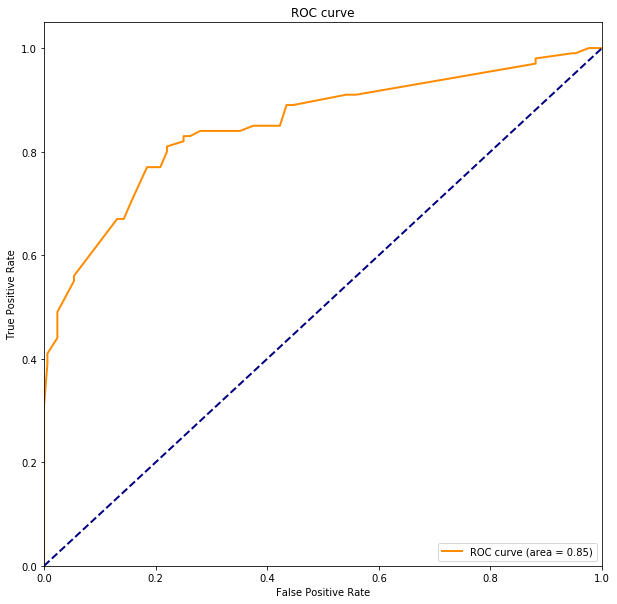

In [81]:
list_LR = []

pred_test1 = model_LR1.predict_proba(x_test_1)
print('model_LR1 Accuracy: %.3f' % accuracy_score(model_LR1.predict(x_test_1), y_test_1))

fpr, tpr, _ = roc_curve(y_true=y_test_1, y_score=pred_test1[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
draw_graph(fpr, tpr, roc_auc)

list_LR.append(accuracy_score(model_LR1.predict(x_test_1), y_test_1))

### 5.1 LogisticRegression

- x_data_2 : 결측치를 드랍해버렸고, 연령대를 범주로 변경하지 않았습니다.

model_LR2 Accuracy: 0.828


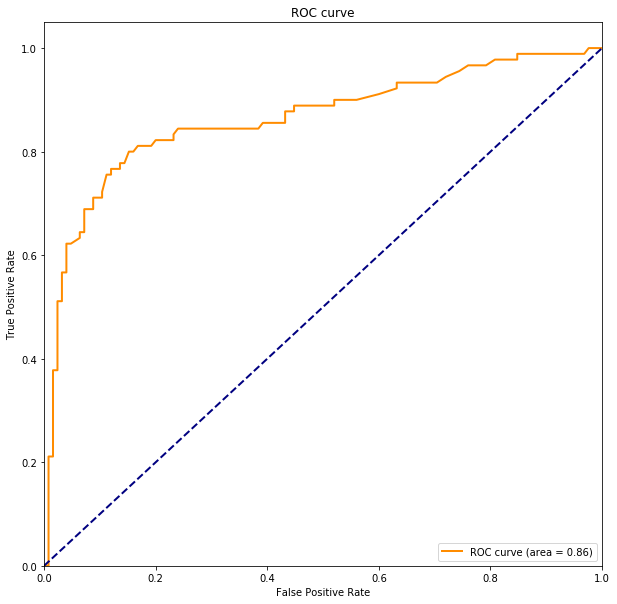

In [82]:
pred_test2 = model_LR2.predict_proba(x_test_2)
print('model_LR2 Accuracy: %.3f' % accuracy_score(model_LR2.predict(x_test_2), y_test_2))

fpr, tpr, _ = roc_curve(y_true=y_test_2, y_score=pred_test2[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
draw_graph(fpr, tpr, roc_auc)

list_LR.append(accuracy_score(model_LR2.predict(x_test_2), y_test_2))

### 5.1 LogisticRegression

- x_data_3 : 결측치를 중윗값으로 채워주었고, 연령대를 범주형으로 변환하지 않았습니다.

model_LR3 Accuracy: 0.791


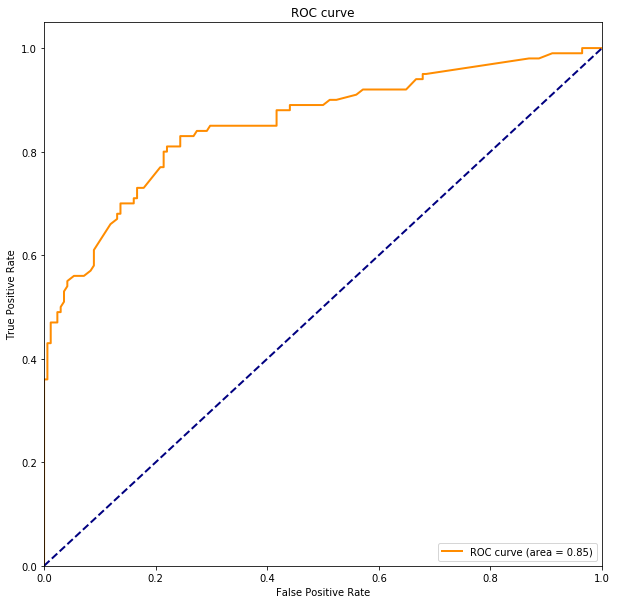

In [83]:
pred_test3 = model_LR3.predict_proba(x_test_3)
print('model_LR3 Accuracy: %.3f' % accuracy_score(model_LR3.predict(x_test_3), y_test_3))

fpr, tpr, _ = roc_curve(y_true=y_test_3, y_score=pred_test3[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
draw_graph(fpr, tpr, roc_auc)

list_LR.append(accuracy_score(model_LR3.predict(x_test_3), y_test_3))

### 5.1 LogisticRegression

-  x_data_4 : x_data_1에 Fare 값을 추가하였습니다.

model_LR4 Accuracy: 0.791


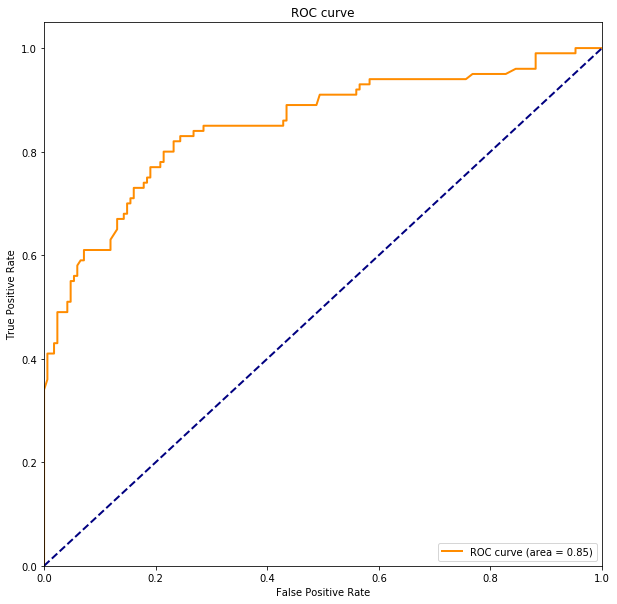

In [84]:
pred_test4 = model_LR4.predict_proba(x_test_4)
print('model_LR4 Accuracy: %.3f' % accuracy_score(model_LR4.predict(x_test_4), y_test_4))

fpr, tpr, _ = roc_curve(y_true=y_test_4, y_score=pred_test4[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
draw_graph(fpr, tpr, roc_auc)

list_LR.append(accuracy_score(model_LR4.predict(x_test_4), y_test_4))

##### 5.1 LogisticRegression

-  x_data_5 : x_data_1에 Fare, SibSp, Parch열을 추가하여 최대한 많은 열을 살려보았습니다. 

model_LR5 Accuracy: 0.791


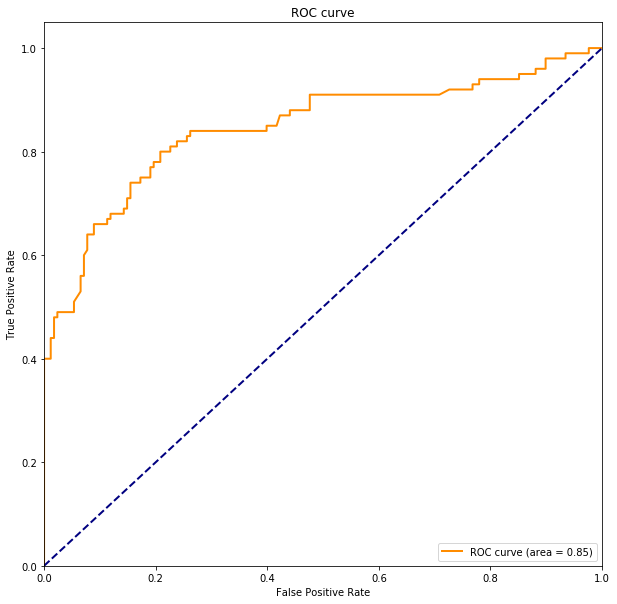

In [112]:
pred_test5 = model_LR5.predict_proba(x_test_5)
print('model_LR5 Accuracy: %.3f' % accuracy_score(model_LR5.predict(x_test_5), y_test_5))

fpr, tpr, _ = roc_curve(y_true=y_test_5, y_score=pred_test5[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
draw_graph(fpr, tpr, roc_auc)

list_LR.append(accuracy_score(model_LR5.predict(x_test_5), y_test_5))

### 5.1 LogisticRegression

- 그래프를 하나로 합쳐 비교해보았습니다.


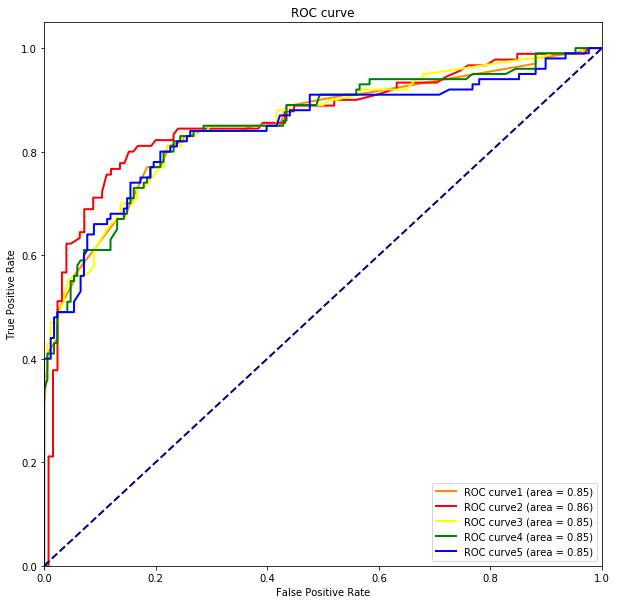

In [86]:
# Case 1
fpr1, tpr1, _ = roc_curve(y_true=y_test_1, y_score=pred_test1[:,1])
roc_auc1 = auc(fpr1, tpr1) # AUC 면적의 값 (수치)

# Case 2
fpr2, tpr2, _ = roc_curve(y_true=y_test_2, y_score=pred_test2[:,1])
roc_auc2 = auc(fpr2, tpr2) # AUC 면적의 값 (수치)

# Case 3
fpr3, tpr3, _ = roc_curve(y_true=y_test_3, y_score=pred_test3[:,1])
roc_auc3 = auc(fpr3, tpr3) # AUC 면적의 값 (수치)

# Case 4
fpr4, tpr4, _ = roc_curve(y_true=y_test_4, y_score=pred_test4[:,1])
roc_auc4 = auc(fpr4, tpr4) # AUC 면적의 값 (수치)

# Case 5
fpr5, tpr5, _ = roc_curve(y_true=y_test_5, y_score=pred_test5[:,1])
roc_auc5 = auc(fpr5, tpr5) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))

plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve1 (area = %0.2f)' % roc_auc1) # ---> 점들의 데이터를 받아 선으로 연결해준다.
plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve2 (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='yellow', lw=2, label='ROC curve3 (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='green', lw=2, label='ROC curve4 (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='blue', lw=2, label='ROC curve5 (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 대각선을 그려주는 것

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()
    


- LogisticRegression 에서는 결측치를 drop한 x_data_2가 몇 0.86으로 가장 높게 나왔습니다.
- 그러나, 매우 큰 격차를 보이지도 않았으며,
- 생각만큼 점수가 나와주지 않아 다른 모델을 선정해보기로 하였습니다.


### 5.2 Kernelized Support Vector Machine

- x_data, y_data에 대하여 Kernelized Support Vector Machine을 적용해봤습니다.

In [87]:
list_SVC = []

print("Case 1")
print("Accuracy on Training set: {:.3f}".format(svc_1.score(x_train_1, y_train_1)))
print("Accuracy on Test set: {:.3f}".format(svc_1.score(x_test_1, y_test_1)))
print("\n")
list_SVC.append(svc_1.score(x_test_1, y_test_1))

print("Case 2")
print("Accuracy on Training set: {:.3f}".format(svc_2.score(x_train_2, y_train_2)))
print("Accuracy on Test set: {:.3f}".format(svc_2.score(x_test_2, y_test_2)))
print("\n")
list_SVC.append(svc_2.score(x_test_2, y_test_2))

print("Case 3")
print("Accuracy on Training set: {:.3f}".format(svc_3.score(x_train_3, y_train_3)))
print("Accuracy on Test set: {:.3f}".format(svc_3.score(x_test_3, y_test_3)))
print("\n")
list_SVC.append(svc_3.score(x_test_3, y_test_3))

print("Case 4")
print("Accuracy on Training set: {:.3f}".format(svc_4.score(x_train_4, y_train_4)))
print("Accuracy on Test set: {:.3f}".format(svc_4.score(x_test_4, y_test_4)))
print("\n")
list_SVC.append(svc_4.score(x_test_4, y_test_4))

print("Case 5")
print("Accuracy on Training set: {:.3f}".format(svc_5.score(x_train_5, y_train_5)))
print("Accuracy on Test set: {:.3f}".format(svc_5.score(x_test_5, y_test_5)))
print("\n")
list_SVC.append(svc_5.score(x_test_5, y_test_5))

Case 1
Accuracy on Training set: 0.815
Accuracy on Test set: 0.799


Case 2
Accuracy on Training set: 0.852
Accuracy on Test set: 0.781


Case 3
Accuracy on Training set: 0.854
Accuracy on Test set: 0.791


Case 4
Accuracy on Training set: 0.867
Accuracy on Test set: 0.728


Case 5
Accuracy on Training set: 0.870
Accuracy on Test set: 0.720




### 5.2 Kernelized Support Vector Machine

- Case 4의 경우 Fare 열의 스케일이 다른열에 비해 큰데, 이것이 영향을 주었을 수도 있으니, 스케일을 조정해주고 해보았습니다.

- 성별 값이 0과 1 둘로 구분하는 방식이여서 그런지 스케일링이 잘못되서 그런지 오히려 Accuracy가 크게 떨어져버렸습니다. 
- Training data에서는 Case 5 가 가장 잘 분석한 것으로 나오나, test에서는 열의수가 적은 Case 1과 Case 3이 더 성능이 좋게 나왔습니다.
- 심지어는 drop으로 결측치를 날려버린 Case 2 보다도 열의 수가 많은 Case 5가 더 낮은 성능으로 나와버렸습니다.

In [88]:
print("Case 4 scaled")
print("Accuracy on Training set: {:.3f}".format(svc_4.score(x_train_4scaled, y_train_4)))
print("Accuracy on Test set: {:.3f}".format(svc_4.score(x_test_4scaled, y_test_4)))
print("\n")

Case 4 scaled
Accuracy on Training set: 0.612
Accuracy on Test set: 0.627




### 5.2 Kernelized Support Vector Machine

- 그래서 Case 5 처럼 여러 열을 빼내고, 결측치를 drop해보기로 하였습니다.

In [89]:
print("Case 6")
print("Accuracy on Training set: {:.3f}".format(svc_6.score(x_train_6, y_train_6)))
print("Accuracy on Test set: {:.3f}".format(svc_6.score(x_test_6, y_test_6)))
print("\n")

Case 6
Accuracy on Training set: 0.884
Accuracy on Test set: 0.688




- 결측치를 drop시켰더니 Training 성능은 올랐으나 Test성능이 현저하게 떨어져버렸습니다.

### 5.2 Kernelized Support Vector Machine

- Hyper-parameter의 문제일 수도 있어 GridSearchCV를 통해 HPO를 진행해 보기로 하였습니다.

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

param_grid = {'C' : [0.01, 0.1, 1, 10, 100, 1000], 
             'gamma' : [10, 1, 0.1, 0.01, 0.001, 0.0001],
             'kernel' : ['rbf']}

grid_5 = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)
grid_6 = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid_5.fit(x_train_5, y_train_5)
grid5_predictions = grid_5.predict(x_test_5)

print('The best parameters are ', grid_5.best_params_)
print('\n')
print(confusion_matrix(y_test_5, grid5_predictions))
print('\n')

print(classification_report(y_test_5, grid5_predictions))

print("Accuracy on Training set: {:.3f}".format(grid_5.score(x_train_5, y_train_5)))
print("Accuracy on Test set: {:.3f}".format(grid_5.score(x_test_5, y_test_5)))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    2.3s finished


The best parameters are  {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


[[139  29]
 [ 30  70]]


              precision    recall  f1-score   support

           0       0.82      0.83      0.82       168
           1       0.71      0.70      0.70       100

   micro avg       0.78      0.78      0.78       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268

Accuracy on Training set: 0.799
Accuracy on Test set: 0.780


In [91]:
grid_6.fit(x_train_6, y_train_6)
grid6_predictions = grid_6.predict(x_test_6)

print('The best parameters are ', grid_6.best_params_)

print('\n')
print(confusion_matrix(y_test_6, grid6_predictions))
print('\n')

print(classification_report(y_test_6, grid6_predictions))


print("Accuracy on Training set: {:.3f}".format(grid_6.score(x_train_6, y_train_6)))
print("Accuracy on Test set: {:.3f}".format(grid_6.score(x_test_6, y_test_6)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    1.2s finished


The best parameters are  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


[[99 26]
 [23 67]]


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       125
           1       0.72      0.74      0.73        90

   micro avg       0.77      0.77      0.77       215
   macro avg       0.77      0.77      0.77       215
weighted avg       0.77      0.77      0.77       215

Accuracy on Training set: 0.874
Accuracy on Test set: 0.772


- HPO를 하고 나니, 결측치를 drop한 Case 6는 test 점수는 높아졌으나 training 점수가 떨어졌고,
- Case 5의 경우도 마찬가지의 모습을 보였습니다.

- 그러나, 5보다 6에서 Confusion matrix에서 TP 대비 FP가 늘어났고, TN 대비 FN 비율이 늘어난것으로 보아,
- 결측치 drop으로 인해 data 수가 적어져서, training과 test에서의 성능이 떨어진것으로 생각됩니다.

In [92]:
grid_2 = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)

grid_2.fit(x_train_2, y_train_2)
print('The best parameters are ', grid_2.best_params_)

grid2_predictions = grid_2.predict(x_test_2)
print(classification_report(y_test_2, grid2_predictions))

print("Accuracy on Training set: {:.3f}".format(grid_2.score(x_train_2, y_train_2)))
print("Accuracy on Test set: {:.3f}".format(grid_2.score(x_test_2, y_test_2)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    1.2s finished


The best parameters are  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       125
           1       0.81      0.70      0.75        90

   micro avg       0.80      0.80      0.80       215
   macro avg       0.81      0.79      0.79       215
weighted avg       0.80      0.80      0.80       215

Accuracy on Training set: 0.824
Accuracy on Test set: 0.805


- Case 2도 HPO를 해주니 test성능이 조금 향상되었습니다.

### 5.3 Gradient Boosting

- 가장 영향을 많이 주는 열을 찾기위해 Gradient Boosting을 사용해보았습니다.

In [93]:
mse5 = mean_squared_error(y_test_5, model_GB5.predict(x_test_5))

print("Case 5\nMSE: %.4f" % mse5)
print("Accuracy score(train) : {0:.3f}".format(model_GB5.score(x_train_5, y_train_5)))
print("Accuracy score(test) : {0:.3f}".format(model_GB5.score(x_test_5, y_test_5)))

mse6 = mean_squared_error(y_test_6, model_GB6.predict(x_test_6))

print("\n\ncase6\nMSE: %.4f" % mse6)
print("Accuracy score(train) : {0:.3f}".format(model_GB6.score(x_train_6, y_train_6)))
print("Accuracy score(test) : {0:.3f}".format(model_GB6.score(x_test_6, y_test_6)))

Case 5
MSE: 0.1256
Accuracy score(train) : 0.631
Accuracy score(test) : 0.463


case6
MSE: 0.1451
Accuracy score(train) : 0.686
Accuracy score(test) : 0.404


- 정답 자체가 0 아니면 1이여서 MSE는 작게 나와버립니다.
- 그리고 데이터와 모델이 맞지 않아서 인지, 데이터 전처리를 잘못해서인지 score가 많이 낮게 나옵니다.

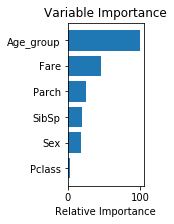

In [111]:
case5_col = list(x_train_5.columns)

feature_importance = model_GB5.feature_importances_ 

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, case5_col)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 그림이 이상하게 너무 크면 이 셀을 한번 더 실행해주세요

- 스케일링이 되지않아서인지, Fare열이 가장 큰 영향력을 보이고 있습니다.

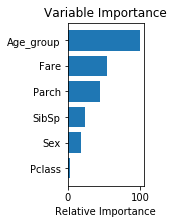

In [110]:
case6_col = list(x_train_6.columns)

feature_importance = model_GB6.feature_importances_ 

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, case6_col)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 그림이 이상하게 너무 크면 이 셀을 한번 더 실행해주세요

- Gradient Boosting으로 했을때 성능이 더 높았던, Case 6 에서는 Age를 범주로 바꾼 Age_group과 Fare, Parch가 영향이 큰 것으로 나타났습니다.

### 5.4 KNN

- KNN과 다른 모델들간의 비교를 해보았습니다.

In [96]:
list_KNN = []

pred_testK1 = model_KNN1.predict_proba(x_test_1)
pred_testK2 = model_KNN2.predict_proba(x_test_2)
pred_testK3 = model_KNN3.predict_proba(x_test_3)
pred_testK4 = model_KNN4.predict_proba(x_test_4)
pred_testK5 = model_KNN5.predict_proba(x_test_5)

print('model_KNN1 Accuracy: %.3f' % accuracy_score(model_KNN1.predict(x_test_1), y_test_1))
list_KNN.append(accuracy_score(model_KNN1.predict(x_test_1), y_test_1))

print('model_KNN2 Accuracy: %.3f' % accuracy_score(model_KNN2.predict(x_test_2), y_test_2))
list_KNN.append(accuracy_score(model_KNN2.predict(x_test_2), y_test_2))

print('model_KNN3 Accuracy: %.3f' % accuracy_score(model_KNN3.predict(x_test_3), y_test_3))
list_KNN.append(accuracy_score(model_KNN3.predict(x_test_3), y_test_3))

print('model_KNN4 Accuracy: %.3f' % accuracy_score(model_KNN4.predict(x_test_4), y_test_4))
list_KNN.append(accuracy_score(model_KNN4.predict(x_test_4), y_test_4))

print('model_KNN5 Accuracy: %.3f' % accuracy_score(model_KNN5.predict(x_test_5), y_test_5))
list_KNN.append(accuracy_score(model_KNN5.predict(x_test_5), y_test_5))

model_KNN1 Accuracy: 0.795
model_KNN2 Accuracy: 0.753
model_KNN3 Accuracy: 0.754
model_KNN4 Accuracy: 0.724
model_KNN5 Accuracy: 0.731


In [97]:
df_models = pd.DataFrame([list_LR, list_SVC, list_KNN],
                        index = ['LR', 'SVC', 'KNN'],
                        columns = ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5'])

df_models

,Case 1,Case 2,Case 3,Case 4,Case 5
LR,0.791045,0.827907,0.791045,0.791045,0.791045
SVC,0.798507,0.781395,0.791045,0.727612,0.720149
KNN,0.794776,0.753488,0.753731,0.723881,0.731343


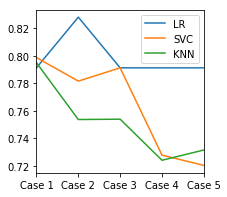

In [109]:
df_models_t = df_models.transpose()
df_models_t.plot()

# 그림이 이상하게 너무 크면 이 셀을 한번 더 실행해주세요

- 결과를 보면, LR 모델은 결측치를 drop한 Case 2 에서 성능이 확 올라갔으나 나머지 Case 1, 3, 4, 5에서는 크게 변하지 않는 모습을 보였습니다.

- SVC 와 KNN은 오히려 결측치를 drop하자 성능이 떨어졌고, 열을 추가할떄 성능이 떨어진걸로 보아, 열을 추가할때 추가적인 처리를 해줬어야 했을것 같습니다.

- 그리고 KNN의 성능이 다른 모델에 비해 부족하다는 것도 직관적으로 볼 수 있었습니다.

### 5.5 XGboost

- 추가로 무엇을 써볼까 고민하다 써보게 되었습니다.

In [99]:
list_XGb = []

preds_xgb1 = model_xgb1.predict(x_test_1)
preds_xgb2 = model_xgb2.predict(x_test_2)
preds_xgb3 = model_xgb3.predict(x_test_3)
preds_xgb4 = model_xgb4.predict(x_test_4)
preds_xgb5 = model_xgb5.predict(x_test_5)

# Case 1
rmse = np.sqrt(mean_squared_error(y_test_1, preds_xgb1))
print("Case 1\nRMSE_1: %f" % (rmse))
print("Accuracy score(train) : {0:.3f}".format(model_xgb1.score(x_train_1, y_train_1)))
print("Accuracy score(test) : {0:.3f}".format(model_xgb1.score(x_test_1, y_test_1)))
list_XGb.append(model_xgb1.score(x_test_1, y_test_1))

# Case 2
rmse = np.sqrt(mean_squared_error(y_test_2, preds_xgb2))
print("\nCase 2\nRMSE_2: %f" % (rmse))
print("Accuracy score(train) : {0:.3f}".format(model_xgb2.score(x_train_2, y_train_2)))
print("Accuracy score(test) : {0:.3f}".format(model_xgb2.score(x_test_2, y_test_2)))
list_XGb.append(model_xgb2.score(x_test_2, y_test_2))

# Case 3
rmse = np.sqrt(mean_squared_error(y_test_3, preds_xgb3))
print("\nCase 3\nRMSE_3: %f" % (rmse))
print("Accuracy score(train) : {0:.3f}".format(model_xgb3.score(x_train_3, y_train_3)))
print("Accuracy score(test) : {0:.3f}".format(model_xgb3.score(x_test_3, y_test_3)))
list_XGb.append(model_xgb3.score(x_test_3, y_test_3))

# Case 4
rmse = np.sqrt(mean_squared_error(y_test_4, preds_xgb4))
print("\nCase 4\nRMSE_4: %f" % (rmse))
print("Accuracy score(train) : {0:.3f}".format(model_xgb4.score(x_train_4, y_train_4)))
print("Accuracy score(test) : {0:.3f}".format(model_xgb4.score(x_test_4, y_test_4)))
list_XGb.append(model_xgb4.score(x_test_4, y_test_4))

# Case 5
rmse = np.sqrt(mean_squared_error(y_test_5, preds_xgb5))
print("\nCase 5\nRMSE_5: %f" % (rmse))
print("Accuracy score(train) : {0:.3f}".format(model_xgb5.score(x_train_5, y_train_5)))
print("Accuracy score(test) : {0:.3f}".format(model_xgb5.score(x_test_5, y_test_5)))
list_XGb.append(model_xgb5.score(x_test_5, y_test_5))


Case 1
RMSE_1: 0.448879
Accuracy score(train) : 0.787
Accuracy score(test) : 0.799

Case 2
RMSE_2: 0.441983
Accuracy score(train) : 0.824
Accuracy score(test) : 0.805

Case 3
RMSE_3: 0.444703
Accuracy score(train) : 0.811
Accuracy score(test) : 0.802

Case 4
RMSE_4: 0.511071
Accuracy score(train) : 0.708
Accuracy score(test) : 0.739

Case 5
RMSE_5: 0.532524
Accuracy score(train) : 0.706
Accuracy score(test) : 0.716


- depth를 10 -> 5 -> 4 순서로 줄여보았는데, 4인 지금도 살짝 오버피팅 느낌이 나서 불안 하지만, 생각보다 train과 test의 격차가 나지 않음을 볼 수 있었습니다.

- 또한 score를 보았을때, Gradient Boosting 보다 XGboost가 이번 프로젝트에서 더 적합한 모델이라고 판단되었습니다.

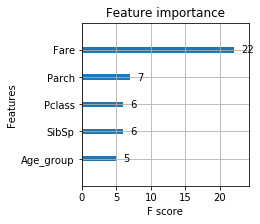

In [107]:
# Case 1
# xgb.plot_importance(model_xgb1)
# plt.rcParams['figure.figsize'] = [3, 3]
# plt.show()

# Case 2
# xgb.plot_importance(model_xgb2)
# plt.rcParams['figure.figsize'] = [3, 3]
# plt.show()

# Case 3
# xgb.plot_importance(model_xgb3)
# plt.rcParams['figure.figsize'] = [3, 3]
# plt.show()

# Case 4
# xgb.plot_importance(model_xgb4)
# plt.rcParams['figure.figsize'] = [3, 3]
# plt.show()

# Case 5
xgb.plot_importance(model_xgb5)
plt.rcParams['figure.figsize'] = [3, 3]
plt.show()

- Case 5에서 열의 중요도를 보았을때, Gradient Boosting과 다른걸 중요하게 보고있음을 알 수 있었습니다.

#### 결정트리

<br>

- ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH
- 상기에러 발생시
- https://www2.graphviz.org/Packages/stable/windows/10/msbuild/Release/Win32/graphviz-2.44.1-win32.zip
- 위 파일을 다운받아 임의의 위치에 압축을 풀어준뒤
- 본 예시의 경우 D:/App/Graphviz 에 압축을 풀었습니다.
- import os
- os.environ["PATH"] += os.pathsep + 'D:/App/Graphviz/bin'

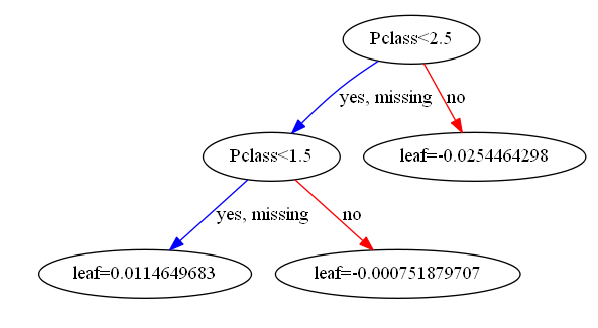

In [105]:
import os
os.environ["PATH"] += os.pathsep + 'D:/App/Graphviz/bin'

xgb.plot_tree(model_xgb1, num_trees=0)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

# 그림이 너무 작게 나오면 한번 더 실행해주면 됩니다.

- xgb 모델이 판단해내는 과정을 볼수도 있었습니다.

In [102]:
df_models2 = pd.DataFrame([list_LR, list_SVC, list_KNN, list_XGb],
                        index = ['LR', 'SVC', 'KNN', 'XGb'],
                        columns = ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5'])

df_models2

,Case 1,Case 2,Case 3,Case 4,Case 5
LR,0.791045,0.827907,0.791045,0.791045,0.791045
SVC,0.798507,0.781395,0.791045,0.727612,0.720149
KNN,0.794776,0.753488,0.753731,0.723881,0.731343
XGb,0.798507,0.804651,0.802239,0.738806,0.716418


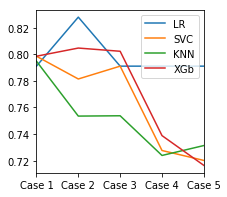

In [108]:
df_models2_t = df_models2.transpose()

df_models2_t.plot()

# 그림이 이상하게 너무 크면 이 셀을 한번 더 실행해주세요

- XGboost 까지 포함하여 그래프를 다시 그려보았습니다.
- XGboost는 저희가 전처리한 데이터에 대해, Case 4까지는 SVC나 KNN에 비해 좋은 성능을 보여주었으나, Case 5에서는 조금 못미치게 되었습니다. 
- XGboost 에서도 열을 추가할때 추가적인 전처리를 해주어야함을 볼 수 있었습니다.

## 결론

- Case 4 와 Case 5 를 준비했을때, Pclass 열 처럼 단계를 나타내기 위해 1,2,3 이 쓰인것 등 과, Age, Fare 열 간의 스케일 차이를 조정해 줄 전처리 과정이 필요했을 것 같고,

- 이는 Fare열 역시 범주화를 했으면 더 좋지 않았나, 아니면 Fare 열을 다른 판단 지표로 쓸 수 있지 않았을까도 생각해보게 되었습니다.

- 그리고 혹시 잘못 작성된 데이터가 있는지 검증 작업도 해봤어도 괜찮았을거라는 생각이 들기도 하였습니다.

- Data를 준비하는데에 있어서 아직 미숙하여, 모델의 성능을 높여주지 못한것이 아쉬웠습니다.
